# Tutorial to estimate the Geographic Spectrum of Shared Alleles (GSSA)

This is a tutorial for estimating the GSSA and use it to uncover the spatial dynamics of potential range expansions. You can run the ipython notebook that created this step-by-step estimation at *notebook/GSSA_calculation.ipynb*.


## STEP 1. Estimating the geo-genetic and geographic-distance histograms

First import the necessary packages:

In [1]:
import os, sys, subprocess, warnings, math, itertools as it, numpy as np
from collections import Counter
from scipy import spatial
import plotly, plotly.plotly as py, matplotlib.pyplot as plt, plotly.tools as tls, plotly.graph_objs as go
plotly.tools.set_credentials_file(username='fern81', api_key='F5a4CnfP6WhcwvPlUYK8')
import warnings
warnings.filterwarnings('ignore')

Then, define the path to the two input files necessary for this step:

- file containing a *mSFS* file describing the joint site frequency spectrum for all sampled localities (see associated bitbucket repository for details on how to obtain this file from a vcf listing the sampled SNPs)

- file listing either the geographic coordinates of sampled localities (one line per sampled locality) or the pairwise 
  effective distance between them [**note:** for the current example, we would use a geographic coordinates files]


In [2]:
infilename = '../example_files/multiSFS_Sampled_SNPs.sfs'
geoname = '../example_files/Sampled_locs.coord'

Using the information contained in these two input files, the calculation proceeds by:

- defining the output file's name:

In [3]:
if '/' in infilename:
    outdir = infilename.split('/')
    outdir = '/'.join(outdir[:-1])
    infile = infilename.split('/')[-1]
else:
    outdir = './'
    infile = infilename
    
prefix = infile.replace('multiSFS_','').replace('.sfs','')
outfilename = '%s/%s.histo' %(outdir, prefix)

- reading the sampled localities' geographic file, extracting all pairwise geographic distances between them, and storing those distances in an *array* (**note:** the grographic file could either list the geographic coordinates of all sampled sites (file suffix "*.coord*"), or provide the pairwise distances between them )file siffix "*.dist*"):

In [4]:
if geoname.endswith('coord'):
    #reading in location coordinates and calculating geographic distance among them
    coords = np.empty([1,3])
    nloc = -1       #stores number of localities sampled
    with open(geoname, 'r') as coordfile:
        for line in coordfile:
            nloc += 1
            if nloc > 0:
                row = line.strip().split()
                row[0] = row[0].replace('P','')
                coords = np.vstack((coords, [float(x) for x in row]))
    coords = np.delete(coords,0,0)
    EuD = spatial.distance.pdist(coords[:,1:],'euclidean')
    AllEuD = list(EuD)
    popnames = coords[:,0]
    
elif geoname.endswith('.dist'):
    #reading in pairwise distances between locations
    with open(geoname, 'r') as distfile:
        n = 0
        for line in distfile:
            n += 1
            if n == 1:
                popnames = [float(x.replace('P','')) for x in line.strip().split(',')]
                nloc = len(popnames)
            else:
                break
    distmat = np.genfromtxt(geoname, delimiter=',')
    distmat = np.delete(distmat,0,0)
    AllEuD = []
    n = -1
    for r in xrange(np.shape(distmat)[0]):
        n += 1
        for c in xrange(np.shape(distmat)[1]):
            if c > n and r!=c:
                AllEuD.append(distmat[r,c])
    EuD = np.array(AllEuD)

else:
    #stop with an error if the incorrect files are provided as input
    sys.exist('Geography file should be either of type ".coord" or ".dist"')

- creating a *list* with the definition of the entries on the *mSFS*, which indicate the set of combinations of minor alleles joint frequencies (see [fastsimcoal2 manual](http://cmpg.unibe.ch/software/fastsimcoal2/man/fastsimcoal26.pdf) for details). **NOTE:** currently this calculation assumes only 1 diploid individual per locality, and biallelic SNPs, though the script could be easily expanded to relax the first assumption.

In [5]:
combs = []
for combi in it.product(range(3), repeat = nloc):
    combs.append(combi)

- labeling distance pairs in the pairwise distance array:

In [6]:
comb = []
for i in it.combinations(popnames, 2):
    comb.append(str(int(i[0])) + '/' + str(int(i[1])))

EuD = np.vstack((comb,EuD))

- creating a common binning scheme for constructing both histograms using Sturge's (1926) rule:

In [7]:
def sturges(vals):
    N = len(vals)
    nbins = math.ceil(math.log(N,2) + 1)
    bins = np.linspace(min(vals), max(vals), nbins)
    return list(bins)

bins = sturges(AllEuD)
bins.insert(0, 0.0)
#a -1 is added below to the binning scheme to temporally store
#the singleton SNPs, which are not used for the GSSA creation
#as they are more prone to correspond to call errors
bins.insert(0, -1.0)

- creating a null histogram expectation exclusively based on samples' relative position to each other (i.e., generating the geographic-distance histogram)

In [8]:
geobins = {}
for l in list(popnames):
    loc = str(int(l))
    dists = [0]     #distance of each locality with itself, that is a distance of zero
    for x in xrange(len(comb)):
        if comb[x].startswith(loc+'/') or comb[x].endswith('/'+loc):
            dists.append(AllEuD[x])
    geo_hist = list(np.histogram(dists, bins)[0])
    geobins.setdefault(loc, geo_hist[1:])

-plotting the geographic histograms just created:

In [ ]:
#plotting geographic-distance histograms
if np.shape(coords)[0] % 2 == 0:
    dim = np.shape(coords)[0] / 2
else:
    dim = np.shape(coords)[0] / 2 + 1
xvals = range(1,len(geo_hist))
mpl_fig, axs = plt.subplots(dim,2,figsize=(10,5))
mpl_fig.suptitle('Geographic_histograms', fontsize=16)
mpl_fig.text(0.04, 0.5, 'Frequency',va='center', rotation='vertical', fontsize=14)
n = 0
row = -1
keys = [int(l) for l in geobins.keys()][:]
keys.sort()
for k in keys:
    n += 1
    if n%2==1:
        row += 1
        col = 0
    elif n%2==0:
        col = 1
    name = 'Loc%s' %k
    axs[row,col].axes.bar(xvals, geobins[str(k)], align='center', alpha=0.5, color='SkyBlue', label=name)
    axs[row,col].xaxis.set_visible(False)
    axs[row,col].legend(loc="upper right")
plotly_fig = tls.mpl_to_plotly(mpl_fig)
figpath = outdir + '/geographic histogram'
py.iplot(plotly_fig, filename=figpath)

- reading *mSFS* file in and generating the geo-genetic histogram (called genHist below):

In [9]:
with open(outfilename, 'w') as outfile:
    #print header to output file storing geographic-distance and geo-genetic histograms
    print >> outfile, 'Pop\t%s\t%s' %('\t'.join(['geoB'+str(x) for x in range(1,(len(bins)-1))]), '\t'.join(['genB'+str(x) for x in range((len(bins)-1))]))
    
    #read in mSFS file
    pathF = infilename
    n = 0
    with open(pathF, 'r') as sfsfile:
        genHist = {}
        for line in sfsfile:
            n += 1
            
            #setting a dictionary for each locality to store the aggregated relative spatial distribution of minor alleles (named as vector "Si" in the publication)
            if n == 1:
                pops = [str(int(x.replace('"P','').replace('"',''))) for x in line.strip().split()[-nloc:]]   #(int(p)-1 because dadi starts pops at 1, but populations in coordinate file are labeled starting at 0
                for p in pops:
                    genHist.setdefault(p,[])
                if set(pops) != set([str(int(x)) for x in popnames]):
                    os.remove(outfilename)
                    sys.exit('Mismatched sampled localities and coordinates!')
    
            #estimating the aggregated relative spatial distribution of minor alleles for each individual (named as vector "Si" in the publication)
            if n == 2:
                sfs = [float(x) for x in line.strip().split()]
                for xbin in xrange(len(sfs)):
                    if sfs[xbin] > 0.0:
                        #the next two lines check for splitted bins (i.e., non-integer) that are present in unfolded SFS
                        if not float(sfs[xbin]).is_integer():
                            os.remove(outfilename)
                            sys.exit('Unfolded SFS provided, folded required!')
                        #the next two lines check whether the combined frequency of each SNP is smaller than that of the alternative allele, which should be the case when using the minor allele for polarization
                        if sum(list(combs[xbin])) > nloc:
                            warnings.warn('Input SFS is not polarized based on minor allele')
                        
                        #storing the distance between copies of the minor alles for each SNP locus and individual
                        for j in xrange(len(combs[xbin])):
                            if combs[xbin][j] != 0:
                                pop = pops[j]
                                popsIN = [x for x in EuD[0,] if x.startswith(pop+'/') or x.endswith('/'+pop)]
                                popsTO = [x.replace(pop+'/','').replace('/'+pop,'') for x in popsIN]
                                indexes = [pops.index(x) for x in popsTO]
                                indexPop = pops.index(pop)
                                distpairs = []
                                count = Counter(list(combs[xbin]))
                                if count.get(0)==(nloc-1):
                                    for freq in xrange(int(sfs[xbin])):
                                        distpairs.append(-1.0)  #special value for private SNPs at frequency of 1. Because such allele may be an error, it is not actually consider in the ragedness index calculation, but here such instances are recorded just in case
                                else:
                                    if combs[xbin][j] == 2:
                                        for freq in xrange(int(sfs[xbin])):
                                            distpairs.append(0.0)
                                    TOcombs = np.array([pops, list(combs[xbin])])
                                    TOcombs = np.delete(TOcombs,indexPop,1)
                                    for k in xrange(len(popsIN)):
                                        ToPop = popsIN[k].split('/')
                                        del ToPop[ToPop.index(pop)]
                                        indexToPop = list(TOcombs[0,]).index(ToPop[0])
                                        if TOcombs[1,indexToPop] != '0':
                                            dist = float(EuD[1,list(EuD[0,]).index(popsIN[k])])
                                            times = int(TOcombs[1,indexToPop]) * combs[xbin][j]
                                            for t in xrange(times):
                                                for freq in xrange(int(sfs[xbin])):
                                                    distpairs.append(dist)
                                genHist[pop].extend(distpairs)
    
    #writing out geographic-distance and geo-genetic histograms to file
    for loc in [str(int(x)) for x in popnames]:
        print >> outfile, 'P%s\t%s\t%s' %(loc, '\t'.join([str(x) for x in geobins.get(loc)]), '\t'.join([str(y) for y in list(np.histogram(genHist.get(loc), bins)[0])]))

-plotting the geo-genetic histograms just created:

In [ ]:
#plotting geo-genetic histograms
list(np.histogram(genHist.get(loc), bins)[0])
mpl_fig, axs = plt.subplots(dim,2,figsize=(10,5))
mpl_fig.suptitle('Geo-genetic_histograms', fontsize=16)
mpl_fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)
n = 0
row = -1
for k in keys:
    n += 1
    if n%2==1:
        row += 1
        col = 0
    elif n%2==0:
        col = 1
    genBins = list(np.histogram(genHist.get(str(k)), bins)[0])[1:]
    name = 'Loc%s' %k
    axs[row,col].axes.bar(xvals, genBins, align='center', alpha=0.5, color='SkyBlue', label=name)
    axs[row,col].xaxis.set_visible(False)
    axs[row,col].legend(loc="upper right")
plotly_fig = tls.mpl_to_plotly(mpl_fig)
figpath = outdir + '/geogenetic_histogram'
py.iplot(plotly_fig, filename=figpath)  

- printing output file name to be used in **next step**, which can be run following the other ipython notebook store in the *notebook/* directory named *GSSA_calculation_step2.ipynb*.

In [10]:
print outfilename

../example_files/Sampled_SNPs.histo


## STEP 2. Estimating the GSSA and inferring the sampled locality closest to the expansion source

First load *R*:

In [11]:
%load_ext rpy2.ipython

import warnings 
warnings.filterwarnings('ignore')

Next, import the necessary *R* packages:

In [12]:
%%R 
suppressMessages(require(matrixStats))
require(MASS)

Then, define the path to the two input files necessary for this second step:

- file generated in **Step 1** containing the geographic-distance and geo-genetic histograms (file suffix "*.histo*")

- file listing the geographic information of sampled localities; either the geographic coordinates (file suffix "*.coord*") or the pairwise distances between localities (file suffix "*.dist*") [**note:** for the current example, we would use a geographic coordinates files]

In [13]:
%%R 
infile = '../example_files/Sampled_SNPs.histo'
geofile = '../example_files/Sampled_locs.coord'

The calculation then proceeds by:

- setting output file names:

In [14]:
%%R 
File.prefix = sub('.histo', '', basename(infile))
File.path = dirname(infile)
resultsFile = sprintf('%s/%s_GSSA_results.tsv', File.path, File.prefix)
raggFile = sprintf('%s/%s_raggedness_index.tsv', File.path, File.prefix) 

- reading the geographic file to get the number and names of sampled localities:

In [15]:
%%R 
if (endsWith(geofile, '.coord')){
    coord = read.table(geofile, header=T, sep='\t')
    dists = as.matrix(dist(coord[,2:3]))
    colnames(dists) = coord$Pop
} else {
    if (endsWith(geofile, '.dist')){
        dists = read.csv(geofile, header=T)
        dists = as.matrix(dists, ncol=ncol(dists))
    }
}
rownames(dists) = colnames(dists)
popnames = colnames(dists)
numloc = length(popnames)

- reading histograms input file:

In [16]:
%%R 
d = read.table(infile, header=TRUE, sep='\t') 

- writing output files header:

In [17]:
%%R 
write(paste('Source', 'Longitude', 'Latitude', sep='\t'), file=resultsFile, append=F)
write(paste(paste(d$Pop[1:numloc], collapse='\t'), sep='\t'), file=raggFile, append=F)

- defining function to calculate the GSSA statistic:

In [18]:
%%R 
GSSA.func = function(data){
    #data = dataframe storing the geographic-distance and geo-genetic distances
    
    rownames(data) = data$Pop
    geoBins = data[grep('geoB',names(data))]
    genBins = data[grep('genB',names(data))[-1]]   
    #the [-1] above is to remove the singleton category bin, which is not used in the GSSA calculation geoBins.corrected = genBins \
    genBins.corrected = genBins
    genBins.corrected[which(!is.na(genBins.corrected), arr.ind=TRUE)] = NA
    reg = lm(as.numeric(genBins) ~ as.numeric(geoBins))
    for (i in 1:length(genBins.corrected)){
        genBins.corrected[i] = abs(reg$residuals[i])
    }
    return(genBins.corrected)
}

- defining function to plot GSSA vectors for each sampled locality:

In [19]:
%%R 
plot.gssa = function(x, Peaks){
    #x = dataframe row storing the corrected geo-genetic distances (i.e., GSSA)
    #Peaks = vector of estimated raggedness indexes
    
    if((length(Peaks) %% 2) == 0) {
        rows = length(Peaks) / 2
    } else {
        rows = (length(Peaks) / 2) + 1
    }
    par(mfrow=c(rows,2))
    
    for (i in 1:nrow(x)){
        x = x[order(Peaks),]
        barplot(as.numeric(x[i,]), ylab='Frequency', main=sprintf('GSSA: %s [Rank: %d]', rownames(x)[i], i))
    }
}

- defining a function to calculate Harpending's (1994) raggedness index:

In [20]:
%%R 
diff.func = function(x){
     #x = dataframe row storing the geographic-distance and corrected geo-genetic distances (i.e., GSSA)

     require(MASS)
     null = x[grep('geoB',names(x))]
     sfs = x[grep('genB',names(x))]
     non0bins = as.numeric(which(null!=0.0))
     sfs = sfs[non0bins]
     comb = combn(seq(length(sfs)),2)
     paired = combn(sfs,2)
     paired = paired[,which(colDiffs(comb)==1)]
     paired = matrix(as.numeric(paired), nrow=2)
     diffs2 = (colDiffs(paired))^2
     return((sum(diffs2)/(length(non0bins)-1)))
}

- putting together all functions described above into a wrapper function to identify the sampled location closest to the expansion source, plot the GSSA vectors, and write results to outpu files:

In [21]:
%%R 
ragg.func = function(data, numloc){
    #data = dataframe storing the geographic-distance and geo-genetic distances
    #numloc = number of sampled localities 
    
    #estimating the GSSA vectors for each sampled population
    #gssa = apply(data, 1, GSSA.func) --> for an unknow reason apply fails here in the notebook, so:
    gssa = data.frame()
    for (i in 1:nrow(data)){
        gssa = rbind(gssa, GSSA.func(data[i,]))
    }
    gssa = as.data.frame(gssa)
    
    #calculating Harpending's (1994) raggedness index on GSSA vectors
    #Peaks = apply(cbind(geoBins = data[grep('geoB',names(data))], gssa), 1, diff.func)  --> for an unknow reason apply fails here in the notebook, so:
    Peaks = rep(NA,numloc)
    names(Peaks) = popnames
    for (i in 1:nrow(data)){
        Peaks[i] = diff.func(cbind(geoBins = data[i,grep('geoB',names(data))], gssa[1,]))
    } 
    
    #identify sampled location closest to range expansion source
    source = names(Peaks)[which.min(Peaks)]
    if (endsWith(geofile, 'coordfile')){
        coord.source = coord[which(coord$Pop == source), c('longitude', 'latitude')]
    } else {
        cat('\nWARNING!: coordinate file not provided, potential source coordinates reported as NA\n\n')
        coord.source = c(NA, NA)
    }
    
    #write out results
    write(paste(Peaks, collapse='\t'), file=raggFile, append=T)
    write(paste(source, as.numeric(coord.source[1]), as.numeric(coord.source[2]), sep='\t'), file=resultsFile, append=T)
    
    #plot GSSA vectors (ordered by inferred time of colonization)
    plot.gssa(gssa, Peaks)
   }

- estimating GSSA vectors and sampled lcoation closest to the range expansion source and plotting the GSSA vectors, ranked by estimated time of colonization:


WARNING!: coordinate file not provided, potential source coordinates reported as NA



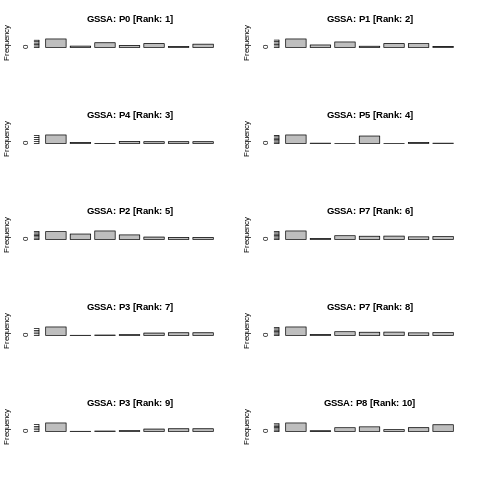

In [22]:
%%R
ragg.func(d, numloc)